In [1]:
# Setup
import boto3, sagemaker, os
from sagemaker.sklearn import SKLearn
from sagemaker import get_execution_role

region = "us-east-1"
bucket = "grey-customer-feedback-bucket" 
prefix = "training"

session = sagemaker.Session()
role = get_execution_role()

# Upload prepared data to S3
train_s3 = session.upload_data(path="data/train_data.csv", bucket=bucket, key_prefix=f"{prefix}/data")
val_s3   = session.upload_data(path="data/val.csv", bucket=bucket, key_prefix=f"{prefix}/data")

train_s3, val_s3

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


('s3://grey-customer-feedback-bucket/training/data/train_data.csv',
 's3://grey-customer-feedback-bucket/training/data/val.csv')

In [ ]:
  %%writefile train.py # Cell 2 I created train.py

In [8]:
# Define Estimator & Train
output_path = "s3://grey-customer-feedback-bucket/models/"

estimator = SKLearn(
    entry_point="train.py",
    role=role,
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version="1.2-1",
    py_version="py3",
    base_job_name="feedback-analyzer-train",
    output_path=output_path
)

estimator.fit({
    "train": train_s3,
    "val": val_s3
})


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: feedback-analyzer-train-2025-08-15-12-23-23-522


2025-08-15 12:23:24 Starting - Starting the training job...
2025-08-15 12:23:39 Starting - Preparing the instances for training...
2025-08-15 12:24:01 Downloading - Downloading input data...
2025-08-15 12:24:31 Downloading - Downloading the training image.....2025-08-15 12:25:38,552 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-08-15 12:25:38,556 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-15 12:25:38,558 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-08-15 12:25:38,576 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-08-15 12:25:38,783 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-08-15 12:25:38,786 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-08-15 12:25:38,805 sagemaker-training-toolkit INFO     No GPUs detected (normal if n

In [17]:
!aws s3 cp s3://grey-customer-feedback-bucket/models/feedback-analyzer-train-2025-08-15-12-23-23-522/output/model.tar.gz .
!tar -tzvf model.tar.gz


download: s3://grey-customer-feedback-bucket/models/feedback-analyzer-train-2025-08-15-12-23-23-522/output/model.tar.gz to ./model.tar.gz
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
-rw-r--r-- root/root     13695 2025-08-15 12:25 model.joblib
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
-rw-r--r-- root/root     39665 2025-08-15 12:25 vectorizer.joblib


In [18]:
# Deploy Endpoint

from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data="s3://grey-customer-feedback-bucket/models/feedback-analyzer-train-2025-08-15-12-23-23-522/output/model.tar.gz",
    role=role,
    entry_point="inference.py",
    framework_version="1.2-1",
    py_version="py3"
)


endpoint_name='feedback-analyzer-endpoint'

predictor = model.deploy(
    instance_type='ml.t2.medium',
    initial_instance_count=1,
    
)

print(f" Endpoint deployed: {endpoint_name}")

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2025-08-15-13-46-03-983
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2025-08-15-13-46-04-474
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2025-08-15-13-46-04-474


--------------! Endpoint deployed: feedback-analyzer-endpoint


In [25]:
# Load feedback test Input from S3 → Run SageMaker Predictions → Save/Upload Results
import sagemaker_inference

sagemaker_inference.main()

☁️ Downloading s3://grey-customer-feedback-bucket/input/feedback_samples.csv ...
🔗 Sending 10 records to SageMaker endpoint 'sagemaker-scikit-learn-2025-08-15-13-46-04-474'...
✅ Saved predictions → data/model_predictions.csv
☁️ Uploaded to s3://grey-customer-feedback-bucket/predictions/model_predictions.csv


,text,sentiment,emoji
0,Absolutely fantastic service! Exceeded my expe...,Positive,😊
1,Worst purchase ever. Completely disappointed w...,Negative,😠
2,"The product is okay, but shipping took longer ...",Mixed,🤔
3,Customer support resolved my issue quickly and...,Positive,😊
4,"Item arrived damaged, and it took weeks to get...",Negative,😠


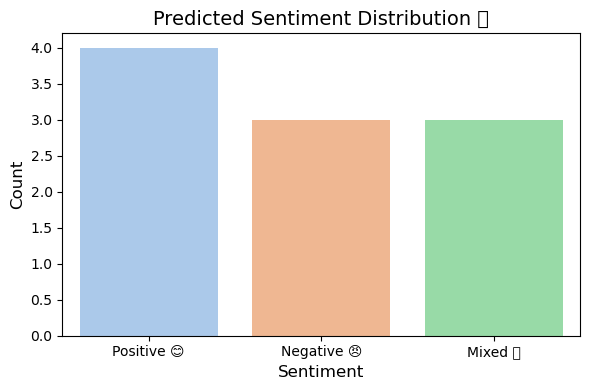

In [24]:
# 📊 Load Model Predictions from S3 → Format DataFrame → Add Emojis → Plot


import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from font")
warnings.filterwarnings("ignore", category=FutureWarning)

import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # for safe dict parsing

# --- S3 config ---
bucket = "grey-customer-feedback-bucket"
key = "predictions/model_predictions.csv"

# --- Load CSV from S3 ---
s3 = boto3.client("s3")
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj["Body"])

# --- Extract 'sentiment' from 'model_raw_result' if needed ---
if "sentiment" not in df.columns and "model_raw_result" in df.columns:
    df["sentiment"] = df["model_raw_result"].apply(
        lambda x: ast.literal_eval(x).get("label") if pd.notna(x) else None
    )

# --- Add emoji mapping ---
emoji_map = {
    "Positive": "😊",
    "Negative": "😠",
    "Mixed": "🤔"
}
df["emoji"] = df["sentiment"].map(emoji_map)

# --- Display clean, formatted DataFrame ---
display(df[["text", "sentiment", "emoji"]].head())

# --- Plot sentiment distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df,
    x="sentiment",
    hue="sentiment",
    order=df["sentiment"].value_counts().index,
    palette="pastel",
    legend=False
)
plt.title("Predicted Sentiment Distribution 💬", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add emoji labels under x‑tick text
ax = plt.gca()
xticks = ax.get_xticks()
labels = [f"{label.get_text()} {emoji_map.get(label.get_text(), '')}" 
          for label in ax.get_xticklabels()]
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

,text,sentiment,emoji
0,Absolutely fantastic service!,positive,😊
1,"Terrible experience, never again.",negative,😠
2,"Okay, but could be better.",positive,😊
3,Exceeded my expectations!,positive,😊
4,Worst purchase ever.,positive,😊
5,I’m satisfied with the product.,negative,😠
6,"Not bad, but not great.",negative,😠
7,Loved it!,positive,😊
8,Disappointed with the quality.,negative,😠
9,"It’s fine, nothing special.",negative,😠


/tmp/ipykernel_10712/161388642.py:51: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


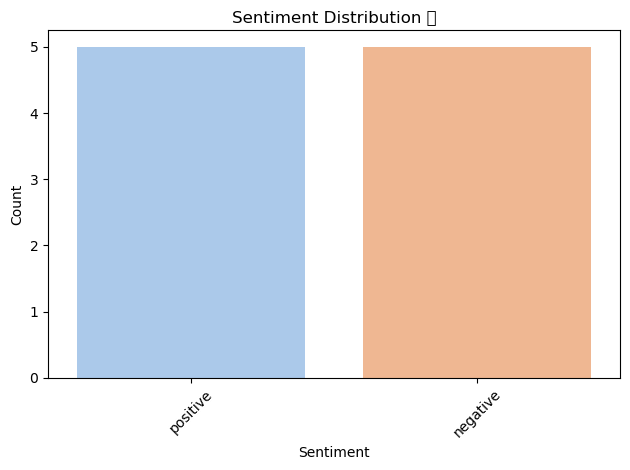

In [ ]:
#Tesing and visualizing more predictions

import boto3, json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Setup
runtime = boto3.client("sagemaker-runtime")
endpoint_name = "feedback-analyzer-endpoint"
label_map = {1: "positive", 0: "negative"}
emoji_map = {"positive": "😊", "negative": "😠", "neutral": "😐"}

# Prediction function
def get_sentiment(text):
    payload = json.dumps({"text": text})
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/json",
        Body=payload
    )
    result = json.loads(response["Body"].read().decode())
    return label_map.get(result[0], "neutral")

# Sample feedback
feedback_samples = [
    "Absolutely fantastic service!",
    "Terrible experience, never again.",
    "Okay, but could be better.",
    "Exceeded my expectations!",
    "Worst purchase ever.",
    "I’m satisfied with the product.",
    "Not bad, but not great.",
    "Loved it!",
    "Disappointed with the quality.",
    "It’s fine, nothing special."
]

# Run predictions
results = [{"text": fb, "sentiment": get_sentiment(fb)} for fb in feedback_samples]
df = pd.DataFrame(results)
df["emoji"] = df["sentiment"].map(emoji_map)

# Show table
display(df)

# Visualize
sns.countplot(data=df, x="sentiment", hue="sentiment", palette="pastel", legend=False)
plt.title("Sentiment Distribution 💬")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Visualizing Model results saved in s3

In [51]:
# Visualize model predictions csv dataset
import boto3
import pandas as pd
import ast

# Reload CSV from S3
bucket = "grey-customer-feedback-bucket"
key = "predictions/model_predictions.csv"
s3 = boto3.client("s3")
response = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))

# Define mappings
sentiment_map = {1: "positive", 0: "negative"}
emoji_map = {"positive": "😊", "negative": "😠"}

# Parse stringified dict and extract sentiment
df["sentiment_label"] = df["model_raw_result"].apply(
    lambda x: sentiment_map.get(ast.literal_eval(x).get("raw", [None])[0])
)

# Map emoji
df["emoji"] = df["sentiment_label"].map(emoji_map)

# Drop raw column
df.drop(columns=["model_raw_result"], inplace=True)

# Preview
df.head(22)


,text,sentiment_label,emoji
0,"The product was amazing, I loved it!",positive,😊
1,Terrible experience. Wouldn't buy again.,negative,😠
2,Support was okay but could be faster.,positive,😊
3,"Delivery was fast, but packaging was poor.",positive,😊
4,Absolutely loved the new update!,positive,😊
5,Not worth the price.,negative,😠
6,Customer service was helpful and polite.,positive,😊
7,"App kept crashing, very frustrating.",positive,😊
8,Easy to use and intuitive interface.,positive,😊
9,Would recommend to friends and family.,negative,😠


/tmp/ipykernel_10712/1790207071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_display", palette="pastel")
/tmp/ipykernel_10712/1790207071.py:41: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


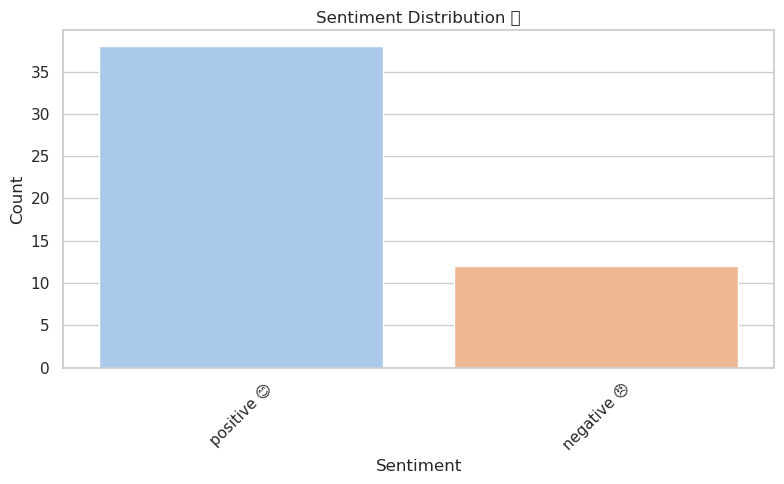

In [48]:
# Visualise bar chart
import boto3
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

# Load CSV from S3
bucket = "grey-customer-feedback-bucket"
key = "predictions/model_predictions.csv"
s3 = boto3.client("s3")
response = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))

# Define mappings
sentiment_map = {1: "positive", 0: "negative"}
emoji_map = {"positive": "😊", "negative": "😠"}

# Parse stringified dict and extract sentiment
df["sentiment_label"] = df["model_raw_result"].apply(
    lambda x: sentiment_map.get(ast.literal_eval(x).get("raw", [None])[0])
)

# Map emoji
df["emoji"] = df["sentiment_label"].map(emoji_map)

# Drop raw column
df.drop(columns=["model_raw_result"], inplace=True)

# Combine label + emoji for plotting
df["sentiment_display"] = df["sentiment_label"] + " " + df["emoji"]

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment_display", palette="pastel")
plt.title("Sentiment Distribution 💬")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
